# Cytotrace analysis

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scvelo as scv
import cellrank as cr

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
Path='/home/mgander/pancreas_multiome/data2'
adata=sc.read_h5ad(f'{Path}/Intestinal_epithelial_adata.h5ad')
adata

AnnData object with n_obs × n_vars = 118336 × 1807
    obs: 'sort_batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_genes', 'sample_id', 'level_1', 'level_2', 'level_3', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'batch', 'publication', 'sample_name', 'tissue', 'derive', 'detail_tissue', 'time', 'time2', 'main_cells', 'protocol', 'tech', 'tech_detail', 'molecular', 'gel', 'leiden', 'day'
    uns: 'leiden', 'level_1_colors', 'level_2_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scPoli', 'X_umap', 'X_umap_initial', 'X_umap_min', 'X_umap_sc'
    layers: 'ambiguous', 'counts', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

# Analysis

In [3]:
scv.pp.moments(adata)

Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:02:17) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:36) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [4]:
from cellrank.kernels import CytoTRACEKernel

ck = CytoTRACEKernel(adata).compute_cytotrace()

In [5]:
ck.compute_transition_matrix(threshold_scheme="soft", nu=0.5)

  0%|          | 0/118336 [00:00<?, ?cell/s]

CytoTRACEKernel[n=118336, dnorm=False, scheme='soft', b=10.0, nu=0.5]

In [7]:
import pickle
tm=ck.transition_matrix
with open(f'{Path}/cyto.pkl', 'wb') as handle:
    pickle.dump(tm, handle, protocol=pickle.HIGHEST_PROTOCOL)

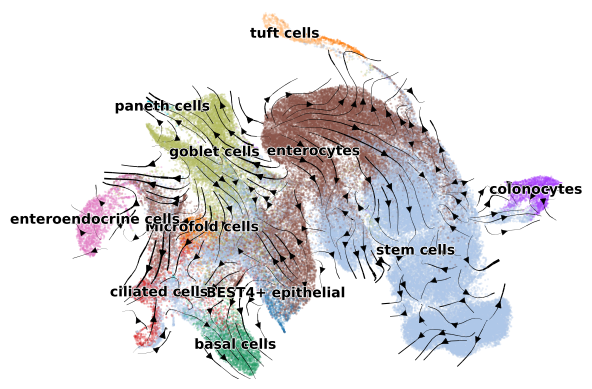

In [8]:
ck.plot_projection(basis='X_umap', color="level_2", recompute=True, title='')

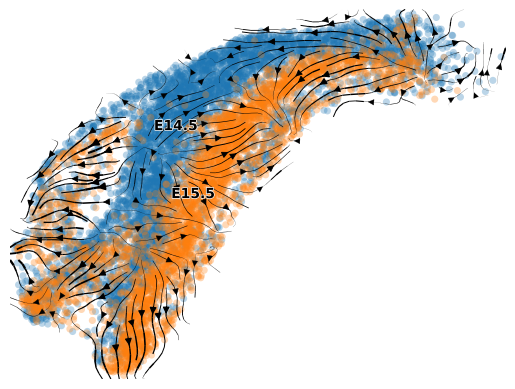

In [12]:
adata.obsm['UMAP']=adata.obsm['umap']
ck.plot_projection(basis='UMAP', color="sample", recompute=True, title='')

In [ ]:
g = cr.estimators.GPCCA(ck)
g.compute_schur(n_components=20)

In [ ]:
g.compute_macrostates(n_states=20, cluster_key="celltype")

/home/mgander/miniconda3/envs/mc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


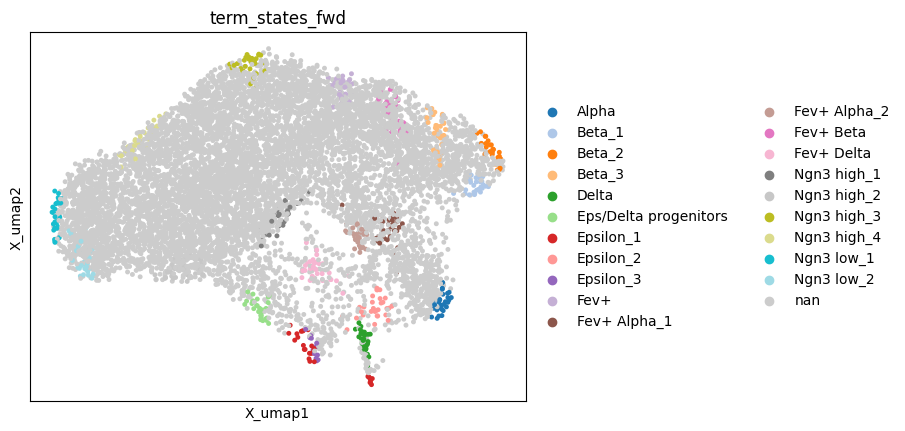

In [14]:
# For plotting all of them
g.predict_terminal_states(method="top_n", n_states=20)
adata.obs['term_states_fwd']=[str(a) for a in adata.obs['term_states_fwd']]

pal=sns.color_palette('tab20').copy()
pal.append([0.8,0.8,0.8])
pall=pal[:len(set(list(adata.obs['term_states_fwd'])))]
pall[-1]=np.array([0.8,0.8,0.8])

sc.pl.embedding(adata, basis='X_umap', color='term_states_fwd', palette=pall, size=50)

## Evaluating using amount of terminal states identified

In [15]:
# I consider these terminal states:
# Alpha, Beta, Epsilon, Delta

terminal_states=['Alpha', 'Beta', 'Epsilon', 'Delta']
def get_number_of_terminal_states(g, adata, n=5, terminal_states=terminal_states):
    g.predict_terminal_states(method="top_n", n_states=n)
    states=list(set(list(adata.obs['term_states_fwd'])))
    states_set=list(set([str(a).split('_')[0] for a in states]))
    n_there=np.sum([a in states_set for a in terminal_states])
    states.remove(np.NaN)
    return(n_there, states)

In [16]:
ns=[]
ss=[]
for i in range(1,21):
    n,s=get_number_of_terminal_states(g, adata, i)
    ns.append(n)
    ss.append(s)
df=pd.DataFrame({'n_term_states':range(1,21), 'n_endocrine_found':ns, 'all_states':ss})
df

,n_term_states,n_endocrine_found,all_states
0,1,1,[Alpha]
1,2,2,"[Alpha, Epsilon_1]"
2,3,2,"[Epsilon_2, Alpha, Epsilon_1]"
3,4,2,"[Ngn3 high_4, Epsilon_1, Epsilon_2, Alpha]"
4,5,2,"[Epsilon_1, Ngn3 high_4, Epsilon_2, Ngn3 low_2..."
5,6,3,"[Epsilon_1, Ngn3 high_4, Epsilon_2, Beta_2, Ng..."
6,7,3,"[Epsilon_3, Epsilon_1, Ngn3 high_4, Epsilon_2,..."
7,8,3,"[Epsilon_3, Epsilon_1, Fev+, Epsilon_2, Ngn3 h..."
8,9,3,"[Epsilon_3, Ngn3 high_2, Epsilon_1, Fev+, Epsi..."
9,10,3,"[Epsilon_3, Ngn3 high_2, Ngn3 high_3, Epsilon_..."


In [17]:
df.to_pickle(f'{Path}/cyto_term_state_numbers.pkl')

## Saving the kernel

In [14]:
#ck.write(f'{Path}/kernels/cyto', write_adata=True, ext='pkl')